In [248]:
"""Run the simulation for a simple two-airport network."""
import os
from itertools import combinations

import click
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import pyro
import seaborn as sns
import torch
import tqdm

import bayes_air.utils.dataloader as ba_dataloader
import wandb
from bayes_air.model import air_traffic_network_model
from bayes_air.network import NetworkState
from bayes_air.schedule import parse_schedule
matplotlib.rcParams["figure.dpi"] = 300

In [2]:
# Load the dataset
top_n = 100
df = pd.read_pickle("../../data/wn_data_clean_cst.pkl")
df = ba_dataloader.top_N_df(df, top_n)
nominal_df, disrupted_df = ba_dataloader.split_nominal_disrupted_data(df)
nominal_dfs = ba_dataloader.split_by_date(nominal_df)
disrupted_dfs = ba_dataloader.split_by_date(disrupted_df)

# Split each disrupted day into 

In [3]:
print(f"# nominal days: {len(nominal_dfs)}")
print(f"# disrupted days: {len(disrupted_dfs)}")
print(f"mean # flights per day (nominal): {[len(d) for d in nominal_dfs]}")
print(f"mean # flights per day (disrupted): {[len(d) for d in disrupted_dfs]}")

# nominal days: 18
# disrupted days: 10
mean # flights per day (nominal): [3617, 3612, 3310, 3878, 3738, 3732, 3732, 3736, 3733, 3348, 3880, 3732, 3732, 3732, 3732, 3879, 3343, 3879]
mean # flights per day (disrupted): [3876, 3876, 3876, 3200, 3552, 3876, 3876, 3876, 3876, 3876]


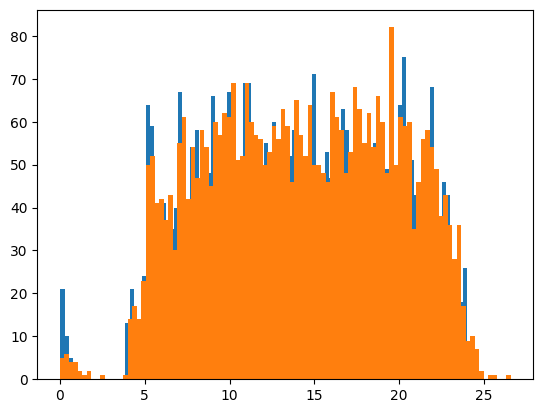

In [4]:
plt.hist(disrupted_dfs[0]["scheduled_departure_time"], bins=100);
plt.hist(nominal_dfs[-1]["actual_departure_time"], bins=100);

In [5]:
# plt.hist(disrupted_dfs[0]["scheduled_departure_time"], bins=100);
disrupted_dfs[0].iloc[:10]

,flight_number,date,origin_airport,destination_airport,scheduled_departure_time,scheduled_arrival_time,actual_departure_time,actual_arrival_time,wheels_on_time,wheels_off_time,cancelled,airport_code_x,origin_time_zone,airport_code_y,destination_time_zone
75354,3376,2022-12-21,PHX,SAN,0.033333,0.616667,0.316667,0.666667,24.216667,0.433333,False,PHX,America/Phoenix,SAN,America/Los_Angeles
16817,1464,2022-12-21,LAS,RNO,0.033333,1.283333,0.350000,1.683333,1.616667,0.550000,False,LAS,America/Los_Angeles,RNO,America/Los_Angeles
5242,4017,2022-12-21,OAK,PHX,0.033333,2.533333,0.350000,2.533333,2.900000,0.500000,False,OAK,America/Los_Angeles,PHX,America/Phoenix
2402,1599,2022-12-21,SEA,OAK,0.033333,2.200000,0.800000,2.733333,2.683333,1.133333,False,SEA,America/Los_Angeles,OAK,America/Los_Angeles
99375,1644,2022-12-21,DEN,SEA,0.066667,2.950000,24.983333,24.983333,24.983333,24.983333,True,DEN,America/Denver,SEA,America/Los_Angeles
43389,737,2022-12-21,DEN,ABQ,0.066667,1.316667,24.983333,24.983333,24.983333,24.983333,True,DEN,America/Denver,ABQ,America/Denver
11623,3265,2022-12-21,DEN,LAS,0.066667,1.866667,24.983333,24.983333,24.983333,24.983333,True,DEN,America/Denver,LAS,America/Los_Angeles
103130,1476,2022-12-21,HNL,ITO,0.083333,1.083333,0.350000,1.316667,1.233333,0.616667,False,HNL,Pacific/Honolulu,ITO,Pacific/Honolulu
4442,3431,2022-12-21,LAS,PHX,0.116667,1.783333,0.850000,2.366667,2.700000,1.033333,False,LAS,America/Los_Angeles,PHX,America/Phoenix
15057,2976,2022-12-21,SJC,LAS,0.116667,1.533333,0.583333,1.883333,1.650000,0.716667,False,SJC,America/Los_Angeles,LAS,America/Los_Angeles


In [6]:
# # Get some summary statistics for each day

# # Get the travel times for each day
# travel_time_dfs = []
# for day in tqdm.tqdm(nominal_dfs[-10:] + disrupted_dfs[:5]):
#     date = day["date"]
#     origin = day["origin_airport"]
#     destination = day["destination_airport"]
#     travel_times = day["actual_arrival_time"] - day["actual_departure_time"]
#     not_cancelled_mask = ~day["cancelled"]
#     travel_time_dfs.append(
#         pd.DataFrame(
#             {
#                 "date": date[not_cancelled_mask],
#                 "origin_airport": origin[not_cancelled_mask],
#                 "destination_airport": destination[not_cancelled_mask],
#                 "travel_time": travel_times[not_cancelled_mask],
#             }
#         )
#     )
# travel_time_df = pd.concat(travel_time_dfs)

# # Get the list of unique OD pairs, regardless of order
# od_pairs = travel_time_df[["origin_airport", "destination_airport"]].drop_duplicates()
# od_pairs = set([tuple(sorted([row["origin_airport"], row["destination_airport"]])) for _, row in od_pairs.iterrows()])
# n_od_pairs = len(od_pairs)
# fig, axs = plt.subplots(n_od_pairs, 2, figsize=(20, 4 * n_od_pairs))
# for i, pair in enumerate(od_pairs):
#     forward_ax = axs[i, 0]
#     reverse_ax = axs[i, 1]
    
#     # Get travel times from origin to destination
#     forward_df = travel_time_df[
#         (travel_time_df["origin_airport"] == pair[0])
#         & (travel_time_df["destination_airport"] == pair[1])
#     ]
#     sns.boxplot(
#         data=forward_df,
#         x="date",
#         y="travel_time",
#         ax=forward_ax,
#     )
#     forward_ax.set_ylabel(f"{pair[0]} -> {pair[1]}")
#     forward_ax.set_ylabel(f"{pair[1]} -> {pair[0]}")
#     forward_ax.set_xticks(forward_ax.get_xticks())
#     forward_ax.set_xticklabels(forward_ax.get_xticklabels(), rotation=45, ha='right')

#     # Get travel times from destination to origin
#     reverse_df = travel_time_df[
#         (travel_time_df["origin_airport"] == pair[1])
#         & (travel_time_df["destination_airport"] == pair[0])
#     ]
#     sns.boxplot(
#         data=reverse_df,
#         x="date",
#         y="travel_time",
#         ax=reverse_ax,
#     )
#     reverse_ax.set_ylabel(f"{pair[1]} -> {pair[0]}")
#     reverse_ax.set_xticks(reverse_ax.get_xticks())
#     reverse_ax.set_xticklabels(reverse_ax.get_xticklabels(), rotation=45, ha='right')

100%|██████████| 10/10 [00:00<00:00, 3979.04it/s]
/tmp/ipykernel_2166285/574514931.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);


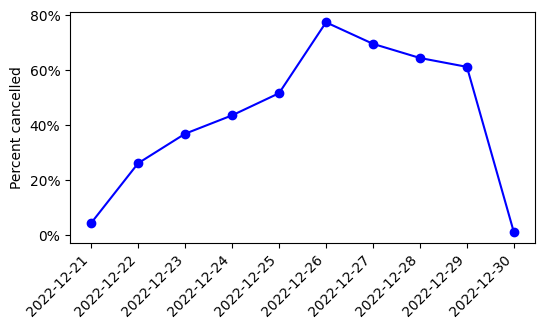

In [7]:
# Plot number of cancellations for each day
dates = []
pct_cancelled = []
for day in tqdm.tqdm(disrupted_dfs):
    dates.append(day["date"].iloc[0])
    pct_cancelled.append(day["cancelled"].mean())

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(dates, pct_cancelled, "bo-")
ax.set_ylabel("Percent cancelled")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
# Mark y axis as percentage
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);

Text(0, 0.5, 'Total cancellations')

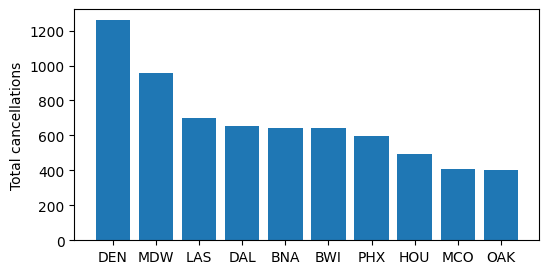

In [8]:
# Over the entire disrupted period, at what airports were flights cancelled?
top_10 = ["DEN", "DAL", "MDW", "PHX", "HOU", "LAS", "MCO", "BNA", "BWI", "OAK"]
cancellations_by_airport = disrupted_df[disrupted_df["origin_airport"].isin(top_10)].groupby(["origin_airport"]).cancelled.sum().sort_values(ascending=False)
cancellations_by_airport = cancellations_by_airport.iloc[:10]
fig, ax = plt.subplots(figsize=(6, 3))
plt.bar(cancellations_by_airport.index, cancellations_by_airport.values)
plt.ylabel("Total cancellations")

In [15]:
df, airport_locations_df = ba_dataloader.load_all_data()
df.head(5)

,Origin Airport Code,Dest Airport Code,Date,Aircraft Tail Number,Diverted Flight,Actual Departure Time,Scheduled Departure Time,Cancelled Flight,Flight Number,Scheduled Arrival Time,...,Taxi In Time,Arrival Delay Air System,Arrival Delay Carrier,Arrival Delay Late Aircraft,Arrival Delay Security,Arrival Delay Weather,Cancelled Flight Code,Taxi Out Time,Bonus Scheduled Arrival Time UTC,Bonus Scheduled Departure Time UTC
0,BUR,OAK,12/01/2022,N940WN,No,08:41,08:40,No,501,09:55,...,7.0,0.0,0.0,0.0,0.0,0.0,NaN,10.0,2022-12-01 17:55:00+00:00,2022-12-01 16:40:00+00:00
1,BUR,OAK,12/01/2022,N7746C,No,20:08,19:40,No,869,21:00,...,6.0,0.0,0.0,16.0,0.0,0.0,NaN,8.0,2022-12-02 05:00:00+00:00,2022-12-02 03:40:00+00:00
2,BUR,OAK,12/01/2022,N942WN,No,16:45,16:20,No,1111,17:35,...,4.0,2.0,9.0,16.0,0.0,0.0,NaN,22.0,2022-12-02 01:35:00+00:00,2022-12-02 00:20:00+00:00
3,BUR,OAK,12/01/2022,N7848A,No,19:46,18:15,No,3019,19:30,...,11.0,0.0,4.0,86.0,0.0,0.0,NaN,11.0,2022-12-02 03:30:00+00:00,2022-12-02 02:15:00+00:00
4,BUR,PHX,12/01/2022,N561WN,No,15:30,15:25,No,400,17:55,...,5.0,0.0,0.0,0.0,0.0,0.0,NaN,15.0,2022-12-02 00:55:00+00:00,2022-12-01 23:25:00+00:00


Text(0, 0.5, 'Avg. # of flights ending at airport')

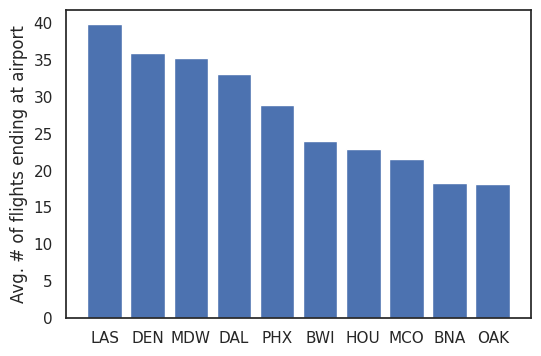

In [219]:
# Filter to prior to Dec 21
import datetime
df_sorted = df[pd.to_datetime(df["Date"]) < pd.Timestamp(datetime.date(2022, 12, 21))].sort_values(by=['Aircraft Tail Number', 'Date', 'Scheduled Arrival Time'])
last_flight = df_sorted.groupby(['Aircraft Tail Number', 'Date']).last()
last_destinations = last_flight["Dest Airport Code"].value_counts()

n_dates = df[pd.to_datetime(df["Date"]) < pd.Timestamp(datetime.date(2022, 12, 21))]["Date"].unique().shape[0]
last_destinations /= n_dates
# Filter to top-10 destinations
last_destinations = last_destinations[last_destinations.index.isin(top_10)]
sns.set(style="white", context="notebook", color_codes=True)
fig, ax = plt.subplots(figsize=(6, 4))
plt.bar(last_destinations.index, last_destinations.values)
plt.ylabel("Avg. # of flights ending at airport")

In [254]:
df_sorted = df[pd.to_datetime(df["Date"]) < pd.Timestamp(datetime.date(2022, 12, 21))].sort_values(by=['Aircraft Tail Number', 'Date', 'Scheduled Arrival Time'])

# Get the airport each tail flies to at the end of each day
last_flight = df_sorted.groupby(['Aircraft Tail Number', 'Date']).last()

# Also mark which flights depart from DEN at some point during the day
through_den = df_sorted.groupby(['Aircraft Tail Number', 'Date'])["Origin Airport Code"].apply(lambda x: "DEN" in x.values)
through_den = through_den.groupby(["Aircraft Tail Number", "Date"]).any()
through_den = through_den.rename("Through DEN")

through_las = df_sorted.groupby(['Aircraft Tail Number', 'Date'])["Origin Airport Code"].apply(lambda x: "LAS" in x.values)
through_las = through_las.groupby(["Aircraft Tail Number", "Date"]).any()
through_las = through_las.rename("Through LAS")

through_phx = df_sorted.groupby(['Aircraft Tail Number', 'Date'])["Origin Airport Code"].apply(lambda x: "PHX" in x.values)
through_phx = through_phx.groupby(["Aircraft Tail Number", "Date"]).any()
through_phx = through_phx.rename("Through PHX")

through_mdw = df_sorted.groupby(['Aircraft Tail Number', 'Date'])["Origin Airport Code"].apply(lambda x: "MDW" in x.values)
through_mdw = through_mdw.groupby(["Aircraft Tail Number", "Date"]).any()
through_mdw = through_mdw.rename("Through MDW")

through_bna = df_sorted.groupby(['Aircraft Tail Number', 'Date'])["Origin Airport Code"].apply(lambda x: "BNA" in x.values)
through_bna = through_bna.groupby(["Aircraft Tail Number", "Date"]).any()
through_bna = through_bna.rename("Through BNA")

through_den_las_phx = (through_phx | through_las | through_den).rename("Through DEN, LAS, or PHX")
through_den_mdw = (through_mdw | through_den).rename("Through DEN or MDW")
through_den_mdw_bna = (through_bna | through_mdw | through_den).rename("Through DEN, MDW, or BNA")
through_any = (through_bna | through_mdw | through_phx | through_las | through_den).rename("Through Any")

# Add a "through denver" column to the last_flight dataframe
last_flight = last_flight.join(through_den, on=["Aircraft Tail Number", "Date"])
last_flight = last_flight.join(through_las, on=["Aircraft Tail Number", "Date"])
last_flight = last_flight.join(through_phx, on=["Aircraft Tail Number", "Date"])
last_flight = last_flight.join(through_den_las_phx, on=["Aircraft Tail Number", "Date"])
last_flight = last_flight.join(through_den_mdw, on=["Aircraft Tail Number", "Date"])
last_flight = last_flight.join(through_den_mdw_bna, on=["Aircraft Tail Number", "Date"])
last_flight = last_flight.join(through_any, on=["Aircraft Tail Number", "Date"])

# Bucket non-top-10 airports into "other"
last_flight = last_flight.reset_index()
last_flight.loc[~last_flight["Origin Airport Code"].isin(top_10), "Origin Airport Code"] = "Other"
# Filter to just the top 10 airports
last_flight = last_flight[last_flight["Dest Airport Code"].isin(top_10)]
# Drop columns except for the destination airport and the "through" columns
last_flight = last_flight[["Dest Airport Code", "Through DEN", "Through LAS", "Through PHX", "Through DEN, LAS, or PHX", "Through DEN or MDW", "Through DEN, MDW, or BNA", "Through Any"]]
# Rename the dest airport column
last_flight = last_flight.rename(columns={"Dest Airport Code": "End-of-day Destination"})

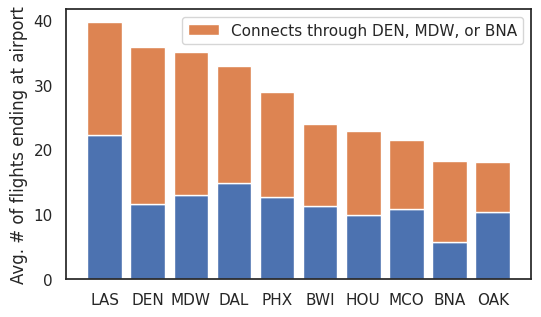

In [234]:
# Get the count of flights ending in each airport
dest_counts = last_flight.groupby(["End-of-day Destination", "Through DEN, MDW, or BNA"]).size().unstack().fillna(0) / n_dates

# Remove DEN and MDW
# dest_counts = dest_counts.drop("DEN", errors="ignore")
# dest_counts = dest_counts.drop("MDW", errors="ignore")
# dest_counts = dest_counts.drop("BNA", errors="ignore")

# # Convert to percentages
# dest_counts = dest_counts.div(dest_counts.sum(axis=1), axis=0)

# Sort by total number of flights
sorted_columns = dest_counts.sum(axis=1).sort_values(ascending=False).index
# sorted_columns = dest_counts[True].sort_values(ascending=False).index
dest_counts = dest_counts.reindex(sorted_columns)

sns.set(style="white", context="notebook", color_codes=True)
fig, ax = plt.subplots(figsize=(6, 3.5))
plt.bar(dest_counts.index, dest_counts[False])
plt.bar(dest_counts.index, dest_counts[True], bottom=dest_counts[False], label="Connects through DEN, MDW, or BNA")
plt.ylabel("Avg. # of flights ending at airport")
plt.legend()

Text(0, 0.5, 'Cancellations')

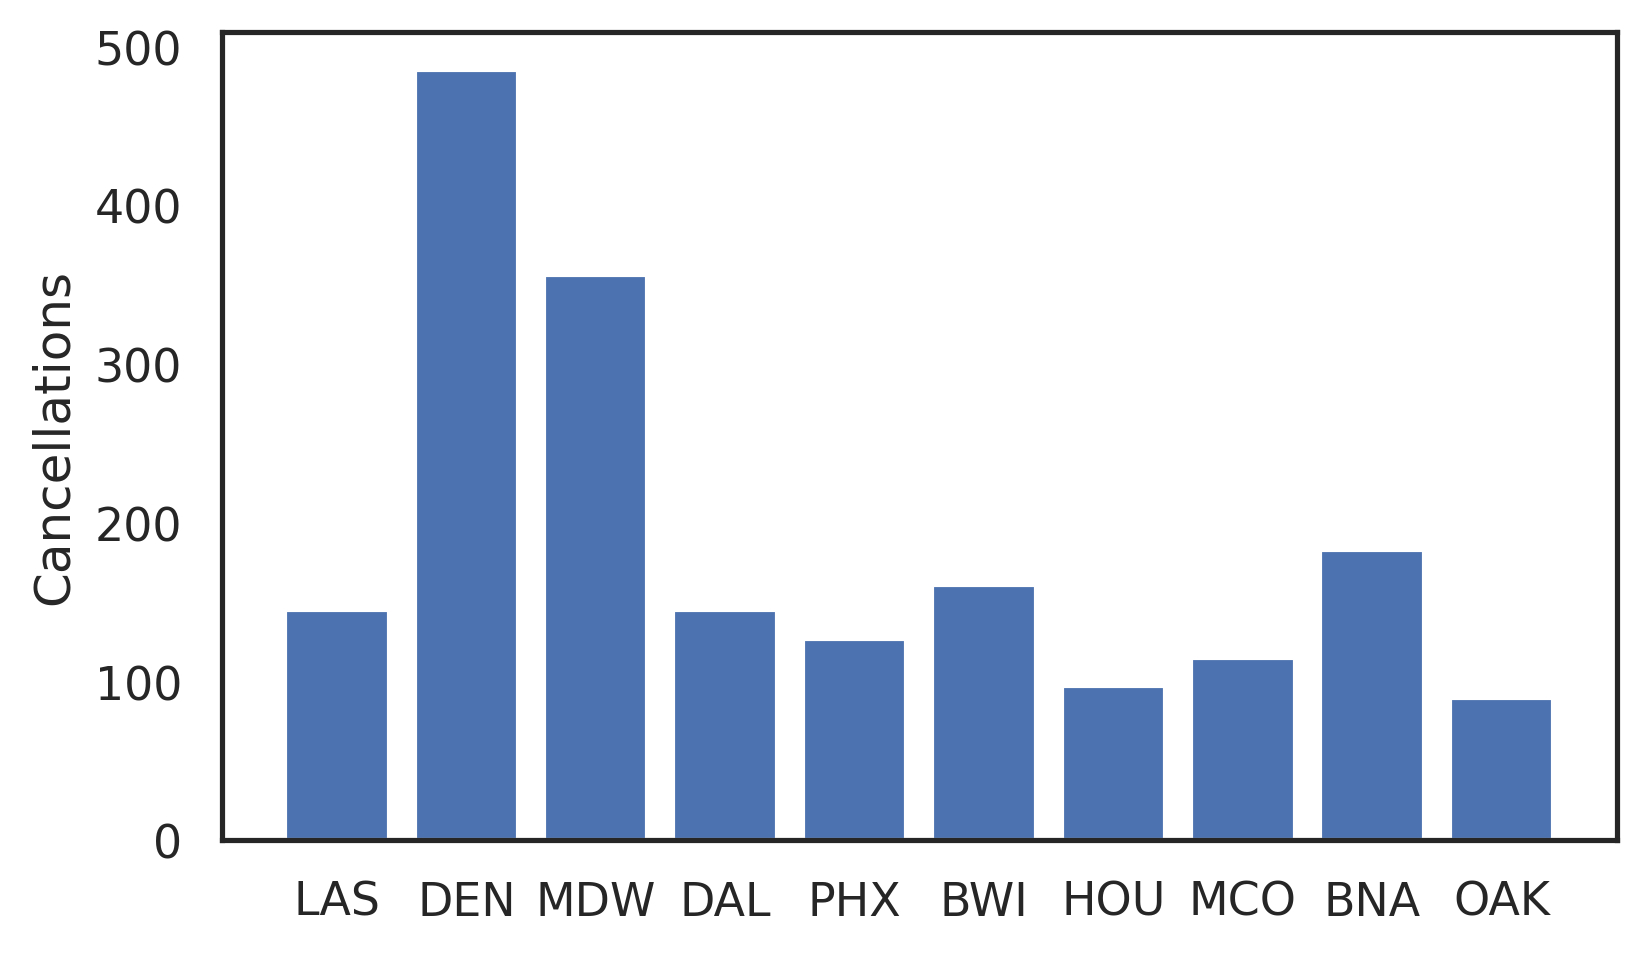

In [265]:
# Get cancellations by airport during the disruption
disruption_mask = (pd.to_datetime(df["Date"]) >= pd.Timestamp(datetime.date(2022, 12, 21))) & (pd.to_datetime(df["Date"]) < pd.Timestamp(datetime.date(2022, 12, 25)))
df_sorted = df[disruption_mask].sort_values(by=['Aircraft Tail Number', 'Date', 'Scheduled Arrival Time'])
cancellations_by_airport = df_sorted[df_sorted["Origin Airport Code"].isin(top_10)].groupby(["Origin Airport Code"])["Cancelled Flight"].apply(lambda x: x == "Yes")
cancellations_by_airport = cancellations_by_airport.groupby(["Origin Airport Code"]).sum()
# # Sort descending
# cancellations_by_airport = cancellations_by_airport.sort_values(ascending=False)

# Order airports by the airports list
cancellations_by_airport = cancellations_by_airport.reindex(sorted_columns)

sns.set(style="white", context="notebook", color_codes=True)
fig, ax = plt.subplots(figsize=(6, 3.5))
plt.bar(cancellations_by_airport.index, cancellations_by_airport, label="$12/21 - 12/24$")
plt.ylabel("Cancellations")
# plt.legend()

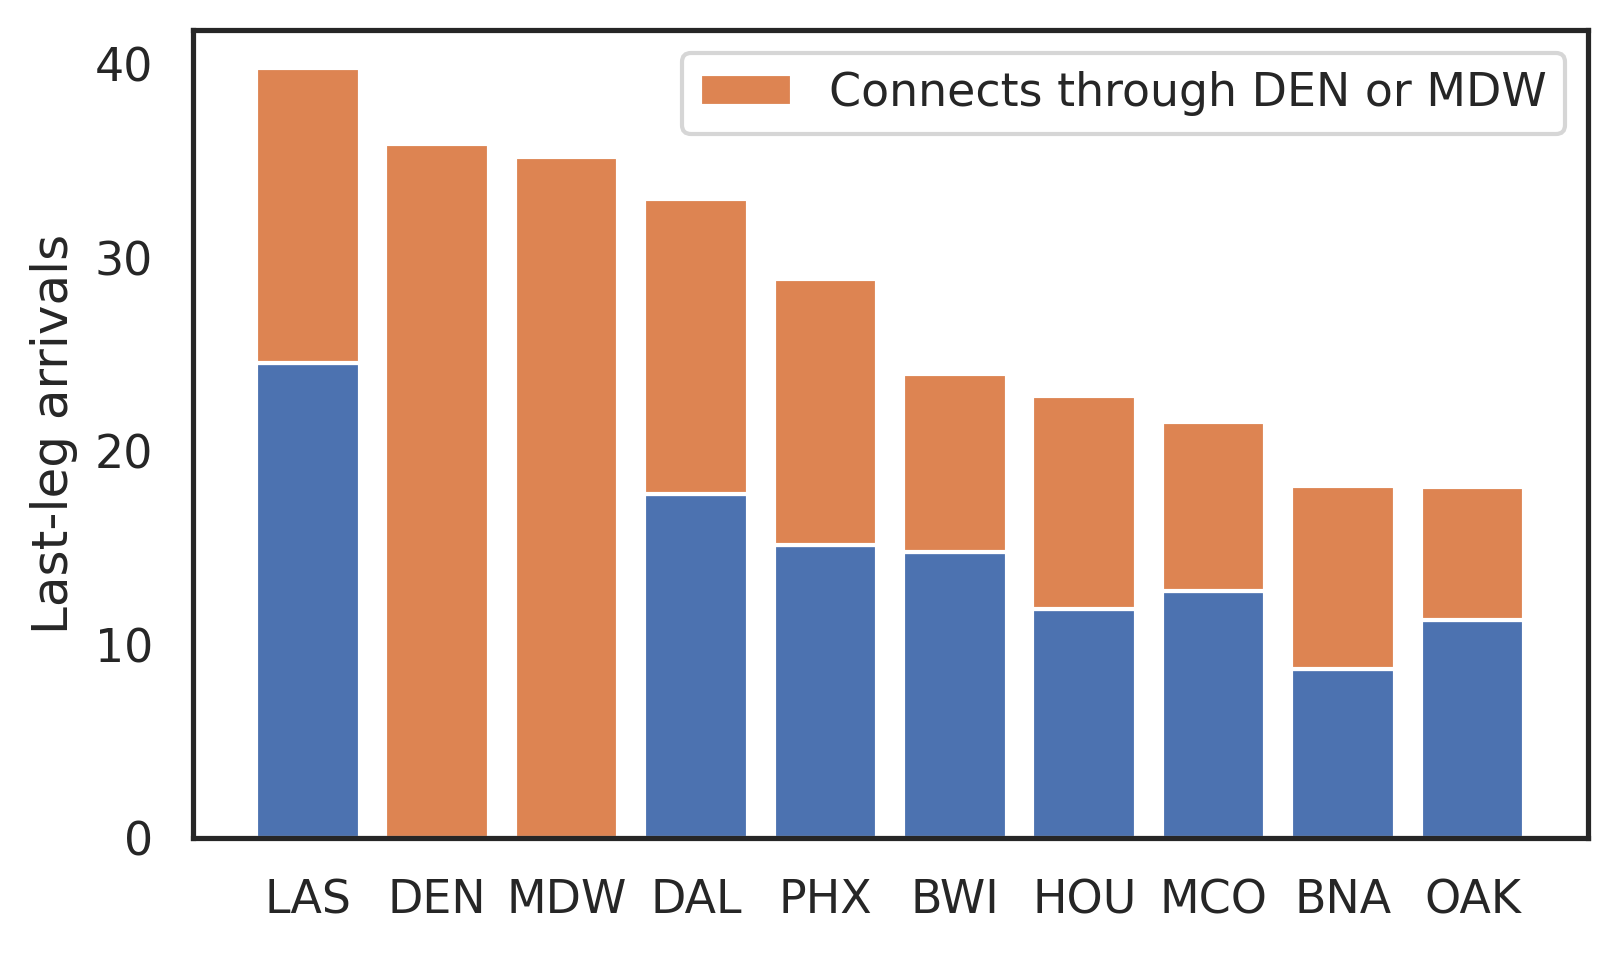

In [253]:
# Get the count of flights ending in each airport
dest_counts = last_flight.groupby(["End-of-day Destination", "Through DEN or MDW"]).size().unstack().fillna(0) / n_dates

# Remove DEN and MDW
# dest_counts = dest_counts.drop("DEN", errors="ignore")
# dest_counts = dest_counts.drop("MDW", errors="ignore")
# dest_counts = dest_counts.drop("BNA", errors="ignore")

# # Convert to percentages
# dest_counts = dest_counts.div(dest_counts.sum(axis=1), axis=0)

# Sort by total number of flights
sorted_columns = dest_counts.sum(axis=1).sort_values(ascending=False).index
# sorted_columns = dest_counts[True].sort_values(ascending=False).index
dest_counts = dest_counts.reindex(sorted_columns)

airports = list(dest_counts.index)
no_connection = list(dest_counts[False])
connection = list(dest_counts[True])

# Mark all flights through DEN or MDW
den_index = airports.index("DEN")
connection[den_index] += no_connection[den_index]
no_connection[den_index] = 0
mdw_index = airports.index("MDW")
connection[mdw_index] += no_connection[mdw_index]
no_connection[mdw_index] = 0

sns.set(style="white", context="notebook", color_codes=True)
fig, ax = plt.subplots(figsize=(6, 3.5))
plt.bar(airports, no_connection)
plt.bar(airports, connection, bottom=no_connection, label="Connects through DEN or MDW")
plt.ylabel("Last-leg arrivals")
plt.legend()

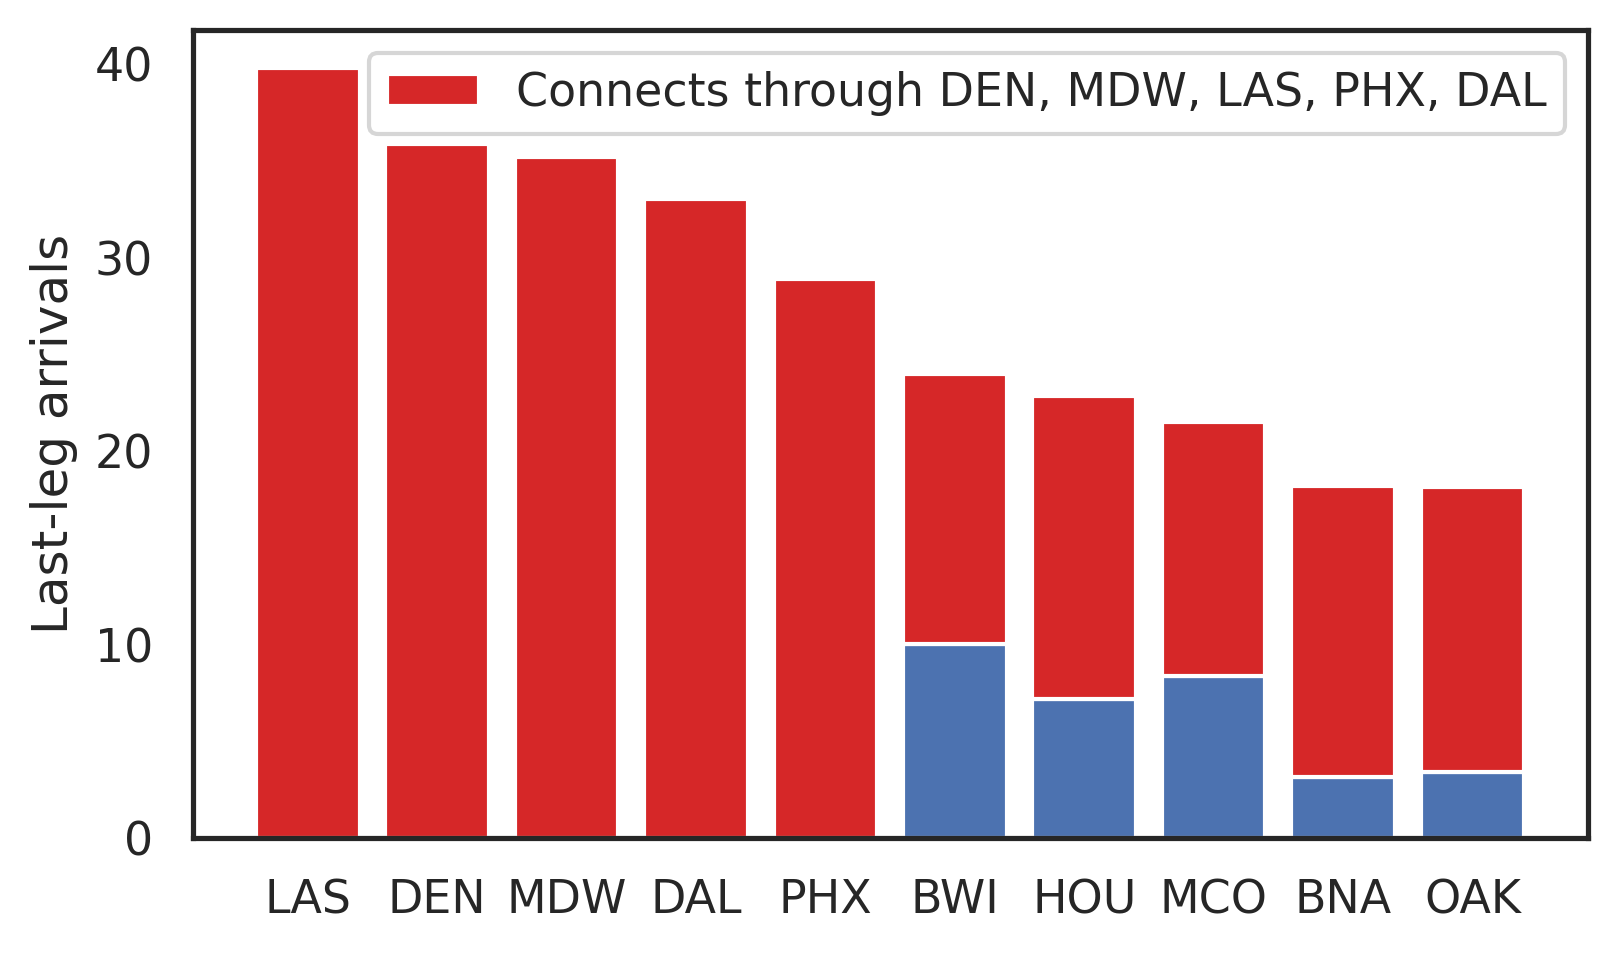

In [259]:
# Get the count of flights ending in each airport
dest_counts = last_flight.groupby(["End-of-day Destination", "Through Any"]).size().unstack().fillna(0) / n_dates

# Remove DEN and MDW
# dest_counts = dest_counts.drop("DEN", errors="ignore")
# dest_counts = dest_counts.drop("MDW", errors="ignore")
# dest_counts = dest_counts.drop("BNA", errors="ignore")

# # Convert to percentages
# dest_counts = dest_counts.div(dest_counts.sum(axis=1), axis=0)

# Sort by total number of flights
sorted_columns = dest_counts.sum(axis=1).sort_values(ascending=False).index
# sorted_columns = dest_counts[True].sort_values(ascending=False).index
dest_counts = dest_counts.reindex(sorted_columns)

airports = list(dest_counts.index)
no_connection = list(dest_counts[False])
connection = list(dest_counts[True])

# Mark all flights through DEN, MDW, LAS, PHX, DAL
den_index = airports.index("DEN")
connection[den_index] += no_connection[den_index]
no_connection[den_index] = 0
mdw_index = airports.index("MDW")
connection[mdw_index] += no_connection[mdw_index]
no_connection[mdw_index] = 0
las_index = airports.index("LAS")
connection[las_index] += no_connection[las_index]
no_connection[las_index] = 0
phx_index = airports.index("PHX")
connection[phx_index] += no_connection[phx_index]
no_connection[phx_index] = 0
dal_index = airports.index("DAL")
connection[dal_index] += no_connection[dal_index]
no_connection[dal_index] = 0

sns.set(style="white", context="notebook", color_codes=True)
fig, ax = plt.subplots(figsize=(6, 3.5))
plt.bar(airports, no_connection)
plt.bar(airports, connection, bottom=no_connection, label="Connects through DEN, MDW, LAS, PHX, DAL", color=plt.get_cmap('tab10').colors[3])
plt.ylabel("Last-leg arrivals")
plt.legend()